# Data loading for training 

Fast streaming of data is extremely important for training ML algorithms. As such, ML libraries including `pytorch` provide useful APIs to load data during training. In this notebook, we go over an example of how to implement `pytorch` APIs for streaming the workshop data.



In [1]:
from __future__ import print_function
import numpy as np
import os, time
import matplotlib.pyplot as plt
%matplotlib inline

There are 2 base `pytorch` modules to be implemented:
* `Dataset` ... represents a blob data instance, defines how data should be read from file, etc.
* `DataLoader` ... for streaming data segments from `Dataset`

In [2]:
from torch.utils.data import Dataset, DataLoader

## Dataset
`Dataset` module needs implementation of two attributes: `__len__` (length of our dataset) and `__getitem__` (called to fetch an item in the ordered dataset). Below, we define `HKDataset` which reads data from files whenever requested.

In [3]:
class HKDataset(Dataset):

    def __init__(self, data_dirs, transform=None):
        """
            Args: data_dirs ... a list of data directories to find files (up to 10 files read from each dir)
                  transform ... a function applied to pre-process data 
        """
        self._transform = transform
        self._files = []
        
        # Load files (up to 10) from each directory in data_dirs list
        for d in data_dirs: self._files += [ os.path.join(d,f) for f in os.listdir(d)[0:10] ]

        # Need to know the total number of events. Compute.
        num_events_v = [np.load(f)['labels'].shape[0] for f in self._files]
        length = np.sum(num_events_v)
        
        # When an event is requested, need to know which file it comes from. Create a file/event index.
        self._file_index  = np.zeros([length],dtype=np.int32)
        self._event_index = np.zeros([length],dtype=np.int32)
        ctr=0
        for findex,num_events in enumerate(num_events_v):
            self._file_index  [ctr:ctr+num_events] = findex
            self._event_index [ctr:ctr+num_events] = np.arange(num_events)
            ctr += num_events

    def __len__(self):
        return len(self._file_index)
            
    def __getitem__(self,idx):
        # Read data file for the specified index=idx
        f = np.load(self._files[self._file_index[idx]])
        # Retrieve event index in this file that corresponds to overall index=idx
        i = self._event_index[idx]
        # Retrieve data & label
        label = f['labels'][i]
        data  = f['event_data'][i]
        # Apply transformation function if necessary
        if self._transform is not None:
            data = self._transform(data)
        return data,label,idx

Let's instantiate `HKDataset` and try loading data

In [4]:
# Data directories: let's use e- and mu-
DATA_DIRS = ['/scratch/kterao/hkml_data/2d/muminus','/scratch/kterao/hkml_data/2d/eminus']
# Craete an instance
ds = HKDataset(DATA_DIRS)
print(len(ds),'total events are loaded!')

25593 total events are loaded!


Access "5th event" and visualize

Entry 5 ... label: 2 ... data shape: (128, 128, 2)


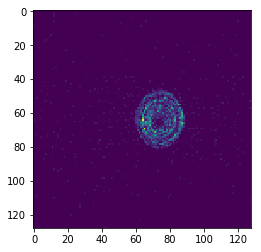

In [5]:
# Access index 5
ENTRY=5
data,label,idx = ds[ENTRY]

# Data shape
print('Entry',ENTRY,'... label:',label,'... data shape:',data.shape)

# Visualize
plt.imshow(data[:,:,0])
plt.show()

## DataLoader
Given a `Dataset` instance, `DataLoader` provides handy features for streaming data including randomization of samples, multi-threaded data read/process (e.g. `transform` function in `Dataset`), etc.. 

The `DataLoader` is for ML training where we typically access data by a chunk, called _batch_ (or sometimes _mini batch_). The number of samples (e.g. events) in each batch is called _batch size_ (or _mini batch size_). When preparing a batch, `DataLoader` combines (or collates) N events where N is the batch size. You need to provide a function to perform this collation.

In [6]:
def HKCollate(batch):
    data  = np.vstack([sample[0] for sample in batch])
    label = [sample[1] for sample in batch]
    idx   = [sample[2] for sample in batch]
    return data,label,idx

Now we can define the dataloader.

In [7]:
loader = DataLoader(ds,
                    batch_size=5, # set the batch size = 50
                    shuffle=True,  # enable randomization of samples in a batch
                    num_workers=1, # number of workers to parallelize data streaming
                    collate_fn=HKCollate # collation method
                   )

Here's how you can loop over 10 batch samples

In [8]:
def loop(loader,loop_limit=3):

    # Let's measure time that takes in each loop
    trecord = np.zeros([loop_limit],dtype=np.float32)
    t = time.time()
    for iteration, batch in enumerate(loader):

        data,label,index = batch

        # Print out some content info
        print('Iteration',iteration,'... time:',time.time()-t,'[s]')
        print('    Labels:',label)
        print('    Index :',index,'\n')
        trecord[iteration] = time.time() - t
        t = time.time()

        # break when reaching the loop limit
        if (iteration+1) == loop_limit:
            break
    return trecord

Let's try running data loader for 5 events

In [9]:
time_record = loop(loader,5)
print('Overall average iteration time:',time_record.mean(),'[s]')
print('First event     iteration time:',time_record[0],    '[s]')
print('After first event average time:',time_record[1:].mean(),'[s]')

Iteration 0 ... time: 6.0243601799 [s]
    Labels: [2, 1, 2, 2, 1]
    Index : [9929, 23361, 13852, 11487, 24578] 

Iteration 1 ... time: 5.70613002777 [s]
    Labels: [2, 1, 1, 2, 2]
    Index : [5811, 18119, 23952, 709, 14916] 

Iteration 2 ... time: 5.89799404144 [s]
    Labels: [2, 2, 2, 1, 1]
    Index : [8966, 5611, 13569, 22054, 16316] 

Iteration 3 ... time: 5.2024679184 [s]
    Labels: [2, 1, 1, 1, 1]
    Index : [6612, 23651, 21302, 18721, 22733] 

Iteration 4 ... time: 6.37095189095 [s]
    Labels: [2, 2, 2, 2, 2]
    Index : [606, 14386, 15103, 11438, 10649] 

Overall average iteration time: 5.841918 [s]
First event     iteration time: 6.0267143 [s]
After first event average time: 5.7957187 [s]


... that was SO SLOW! I hope our impatient team member has not yet thrown his/her laptop yet ;) This slow speed is due to the fact that, for each event, we are performing file open & close. This is very inefficient.

## _Faster_ data streaming

There are three possible solutions to an issue of slow data streaming. 
0. read ALL data in the RAM upfront (e.g. creation of `Dataset`)
1. increase number of _workers_ to read data (i.e. parallelization)
2. combination of 0 and 1: employ parallelization while utilizing some data cache in RAM

The first and last methods are bounded by the size of RAM memory availability. Here, we try the option 1. This can be done by specifying _num workers_ argument value at the construction of `DataLoader`.

In [10]:
loader = DataLoader(ds,
                    batch_size=5, # set the batch size = 50
                    shuffle=True,  # enable randomization of samples in a batch
                    num_workers=20, # number of workers to parallelize data streaming
                    collate_fn=HKCollate # collation method
                   )
time_record = loop(loader,10)
print('Overall average iteration time:',time_record.mean(),'[s]')
print('First event     iteration time:',time_record[0],    '[s]')
print('After first event average time:',time_record[1:].mean(),'[s]')

Iteration 0 ... time: 7.8519949913 [s]
    Labels: [2, 2, 1, 1, 2]
    Index : [4753, 15021, 18908, 21195, 6830] 

Iteration 1 ... time: 0.809750080109 [s]
    Labels: [1, 2, 2, 2, 2]
    Index : [16615, 12437, 4140, 14899, 14000] 

Iteration 2 ... time: 0.000488042831421 [s]
    Labels: [2, 2, 2, 1, 2]
    Index : [8951, 3691, 13423, 20795, 2859] 

Iteration 3 ... time: 5.10215759277e-05 [s]
    Labels: [2, 1, 2, 2, 2]
    Index : [4246, 24115, 8945, 12991, 12054] 

Iteration 4 ... time: 4.6968460083e-05 [s]
    Labels: [2, 1, 1, 2, 2]
    Index : [12918, 17537, 23444, 1387, 11583] 

Iteration 5 ... time: 0.00012993812561 [s]
    Labels: [2, 1, 2, 2, 1]
    Index : [10357, 19752, 8765, 11220, 18703] 

Iteration 6 ... time: 0.0913889408112 [s]
    Labels: [2, 2, 2, 1, 2]
    Index : [8100, 9157, 14194, 22520, 9166] 

Iteration 7 ... time: 3.60012054443e-05 [s]
    Labels: [1, 2, 1, 1, 2]
    Index : [17865, 10158, 24577, 22101, 1558] 

Iteration 8 ... time: 9.51290130615e-05 [s]
    La

The first event takes some time. This is because all workers are initiated and nothing is read yet. However, while 5 workers are reading 5 events to form the first batch, 15 other workers are reading data in parallel and store in a buffer. From the second event and onwards, data in a buffer is loaded (i.e. faster data streaming). At some point, parllel workers and data query will balance out and the speed reaches an equilibrium. You have a good solution when the data streaming speed at the equilibrium is much smaller than the time it takes to consume data, which is an algorithm training step to consume 1 batch of data.

If you have questions/suggestions/concerns, [contact me](mailto:kterao@slac.stanford.edu)!